<a href="https://colab.research.google.com/github/Erikellerx/Projects_in_MLAI/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader, IterableDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, TimeDistributed 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import MeanAbsoluteError

In [134]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Data Preprocess

In [135]:
#https://www.kaggle.com/datasets/kannan1314/amazon-stock-price-all-time
data = pd.read_csv("./drive/MyDrive/UzmaML/Amazon.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [136]:
data.set_index('Date',inplace = True)
data.index =  pd.to_datetime(data.index,format='%Y-%m-%d')
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


There are no null data

In [137]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Data visualization

Text(0.5, 1.0, 'Amazon Stock at all time')

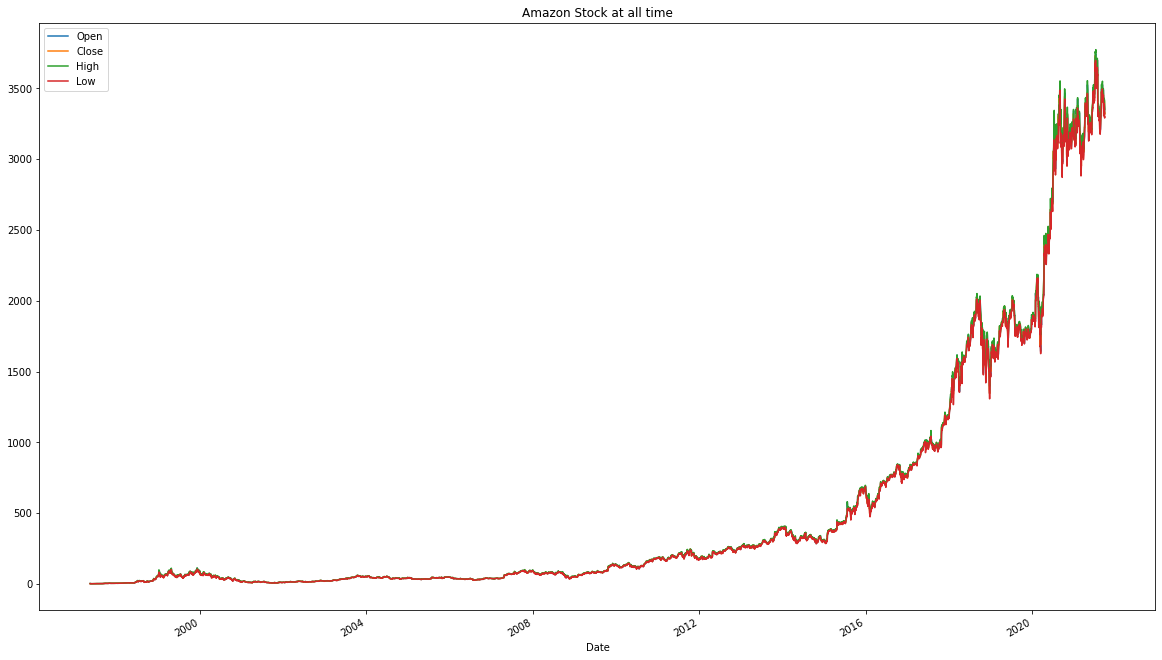

In [138]:
data[['Open','Close','High','Low']].plot(figsize = (20,12))
plt.title('Amazon Stock at all time')

**Training**: 2015 ~ 2018

**Validation**: 2019 ~ 2020

**Testing**: 2021 ~ Now

Since there wasn't much variance before 2015, we trim the old data and preserve since year 2015

In [139]:
from sklearn import preprocessing
#normalizedData = preprocessing.normalize(data)
#normalizedData.shape
trainDF = data['2015':'2018']
valDF = data['2019':'2020']
testDF = data['2021':]
currentDF = data["2015":]

Training, Validation, Testing visualization

Text(0.5, 1.0, 'Amazon Stock at 2021~2022 (Test)')

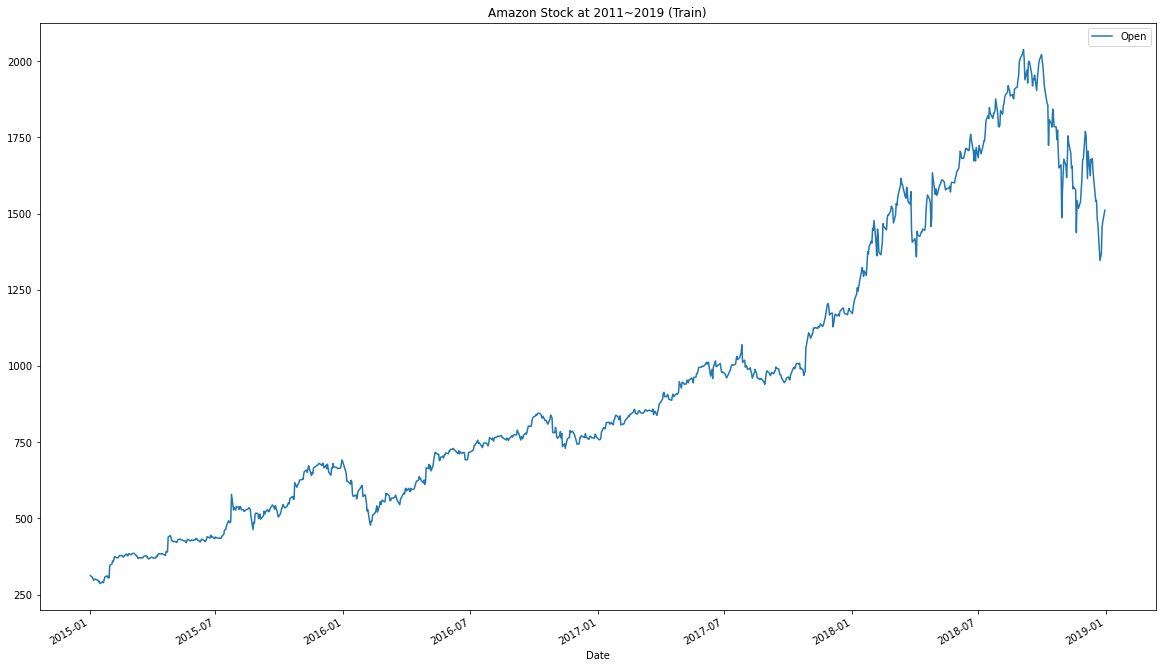

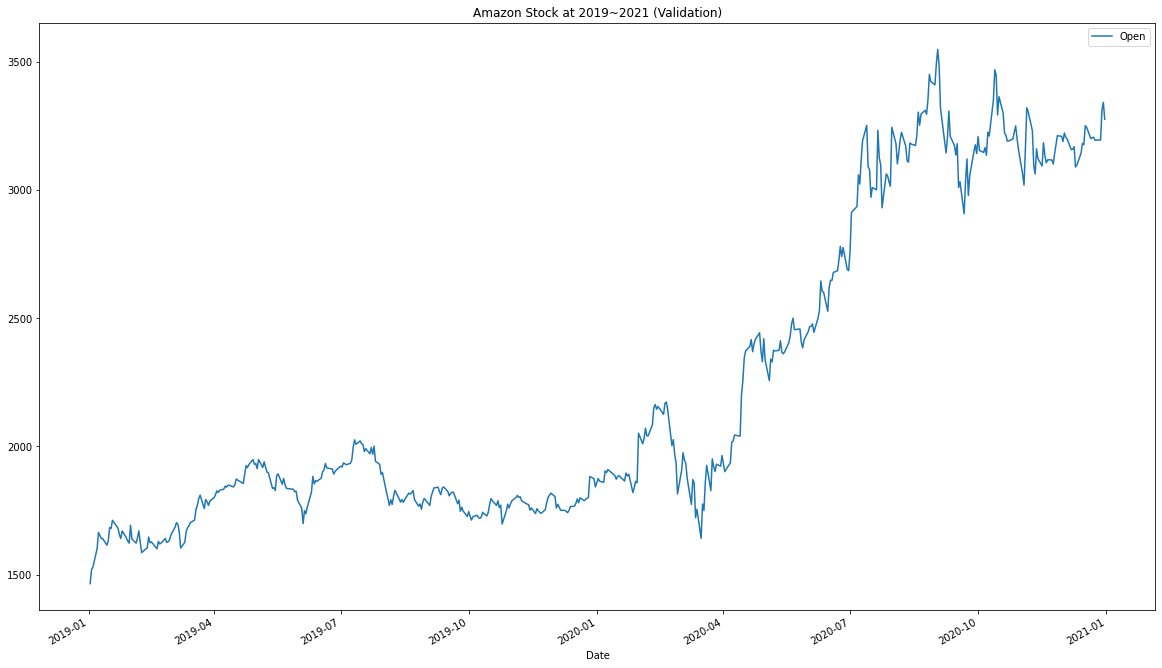

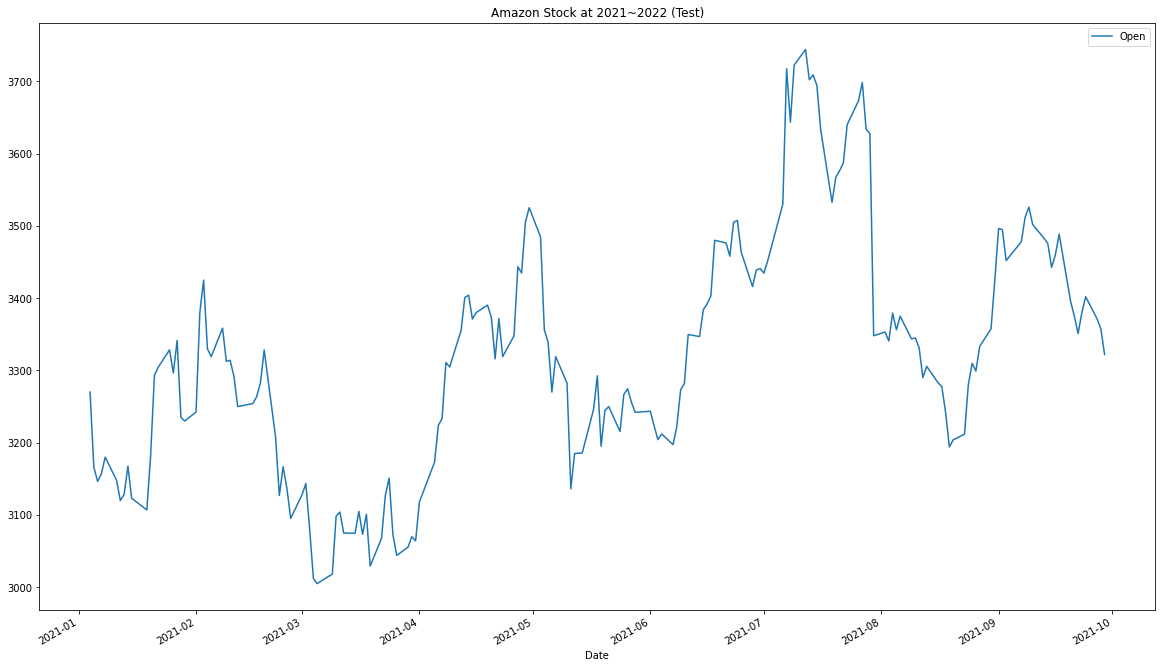

In [140]:
trainDF[['Open']].plot(figsize = (20,12))
plt.title('Amazon Stock at 2011~2019 (Train)')

valDF[['Open']].plot(figsize = (20,12))
plt.title('Amazon Stock at 2019~2021 (Validation)')

testDF[['Open']].plot(figsize = (20,12))
plt.title('Amazon Stock at 2021~2022 (Test)')

**Function define**

In [141]:
def split_sequence(seq, seq_len = 1):
  '''
  This function takes data as input and return sequence of X and y with corresponding sequence length
  '''
  x, y = [], []
  for i in range(len(seq)):

    end_index = i + seq_len

    if end_index > len(seq) - 1:
      break
    seqx, seqy = seq[i:end_index], seq[end_index]
    x.append(seqx)
    y.append(seqy)
    
  return np.array(x), np.array(y)

#SimpleRNN


In [142]:
batch = 16
hidden_size = 50
seq_len = 2

In [143]:
trainData, trainTarget = split_sequence(trainDF.values[:,:1], seq_len=seq_len)
valData, valTarget = split_sequence(valDF.values[:,:1], seq_len=seq_len)
testData, testTarget = split_sequence(testDF.values[:,:1], seq_len=seq_len)

(1004, 2, 1) (1004, 1)
(503, 2, 1) (503, 1)
(185, 2, 1) (185, 1)


(1004, 2, 1)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_42 (Dense)            (None, 25)                1275      
                                                                 
 dense_43 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3,901
Trainable params: 3,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
63/63 - 1s - loss: 110068.1797 - mae: 192.9668 - val_loss: 4877.2075 - val_mae: 52.6695 - 1s/epoch - 19ms/step
Epoch 2/15
63/63 - 0s - loss: 729.9143 - mae: 16.9121 - val_loss: 3188.7329 - val_mae: 38.2920 - 258ms/epoch - 4ms/step
Epoch 3/15
63/63 - 0s - loss: 606.2634 - mae: 14.6099 - val_

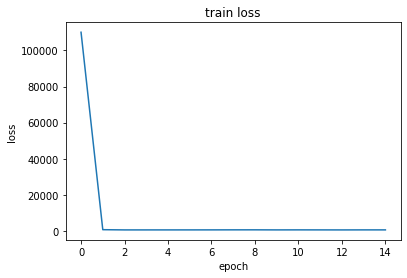

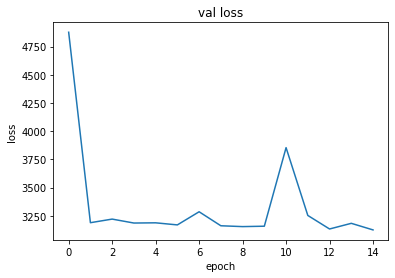

In [144]:
model=Sequential()
model.add(SimpleRNN(hidden_size,activation='relu', input_shape=(seq_len, 1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
model.summary()
history = model.fit(trainData, trainTarget,validation_data = (valData, valTarget) ,  epochs=15, batch_size=batch, verbose=2)

valpred = model.predict(valData)
testpred = model.predict(testData)

mae = MeanAbsoluteError()
error = mae(testpred, testTarget)

print(f"Testing Mean Absolute Error = {error}")

plt.plot(history.history['loss'])
plt.title('train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['val_loss'])
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

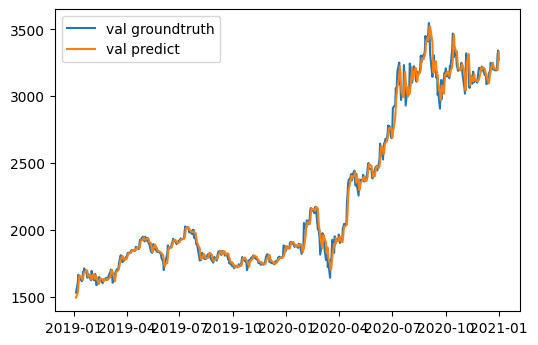

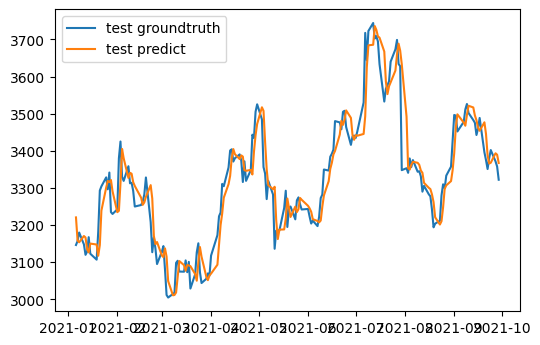

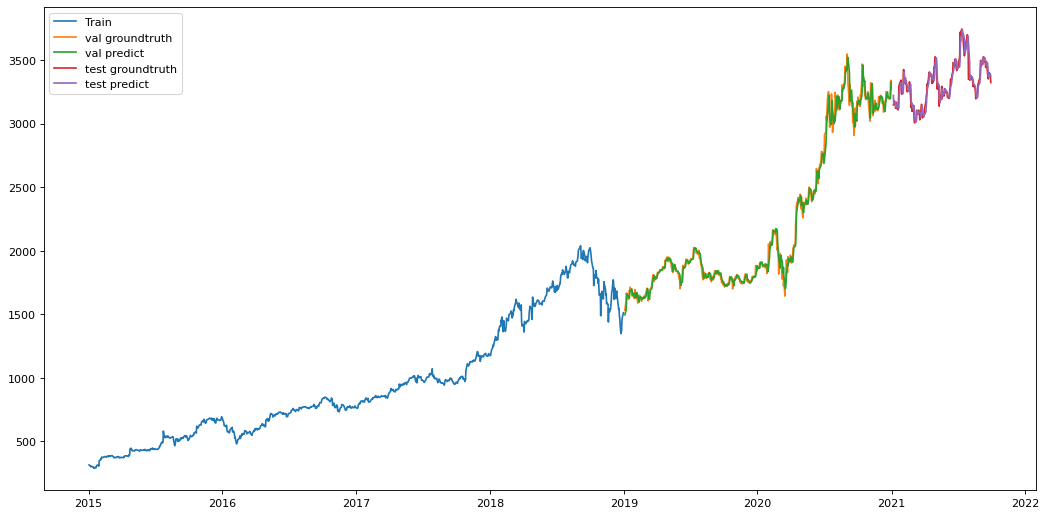

In [145]:
date = valDF.index.values[seq_len:]
plt.figure(dpi = 100)
plt.plot(date, valTarget, label = "val groundtruth")
plt.plot(date, valpred, label = "val predict")
plt.legend()
plt.show()

date = testDF.index.values[seq_len:]
plt.figure(dpi = 100)
plt.plot(date, testTarget, label = "test groundtruth")
plt.plot(date, testpred, label = "test predict")
plt.legend()
plt.show()

plt.figure(figsize=(16,8), dpi = 80)
date = trainDF.index.values[:]
plt.plot(date, trainDF[['Open']], label = "Train")
date = valDF.index.values[seq_len:]
plt.plot(date, valTarget, label = "val groundtruth")
plt.plot(date, valpred, label = "val predict")
date = testDF.index.values[seq_len:]
plt.plot(date, testTarget, label = "test groundtruth")
plt.plot(date, testpred, label = "test predict")
plt.legend()
plt.show()

# LSTM

In [146]:
batch = 16
hidden_size = 50
seq_len = 2

In [147]:
trainData, trainTarget = split_sequence(trainDF.values[:,:1], seq_len = seq_len)
valData, valTarget = split_sequence(valDF.values[:,:1],  seq_len = seq_len)
testData, testTarget = split_sequence(testDF.values[:,:1],  seq_len = seq_len)


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dense_44 (Dense)            (None, 25)                1275      
                                                                 
 dense_45 (Dense)            (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
63/63 - 2s - loss: 792900.8750 - mae: 773.7771 - val_loss: 196363.6094 - val_mae: 425.4971 - 2s/epoch - 27ms/step
Epoch 2/15
63/63 - 0s - loss: 4356.5825 - mae: 42.5860 - val_loss: 3166.1074 - val_mae: 39.1737 - 366ms/epoch - 6ms/step
Epoch 3/15
63/63 - 0s - loss: 556.4113 - mae: 13.8964 - val_loss: 2

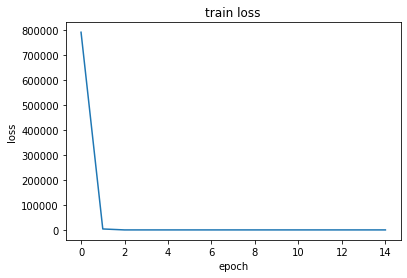

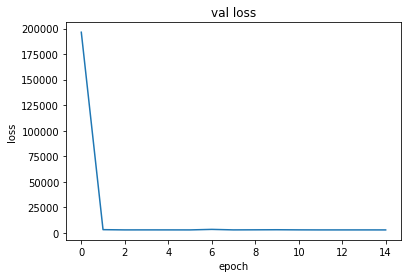

In [148]:
model=Sequential()
model.add(LSTM(hidden_size,activation='relu', input_shape=(seq_len, 1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mae'])
model.summary()
history = model.fit(trainData, trainTarget,validation_data = (valData, valTarget) ,  epochs=15, batch_size=batch, verbose=2)

valpred = model.predict(valData)
testpred = model.predict(testData)

mae = MeanAbsoluteError()
error = mae(testpred, testTarget)

print(f"Testing Mean Absolute Error = {error}")

plt.plot(history.history['loss'])
plt.title('train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['val_loss'])
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

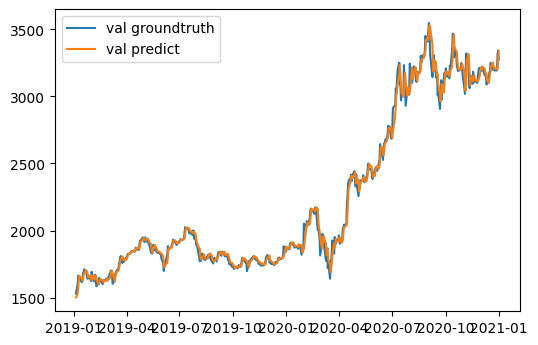

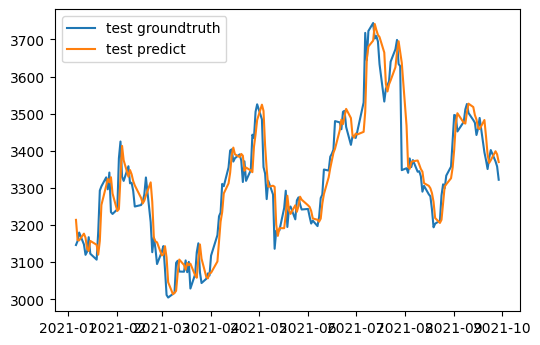

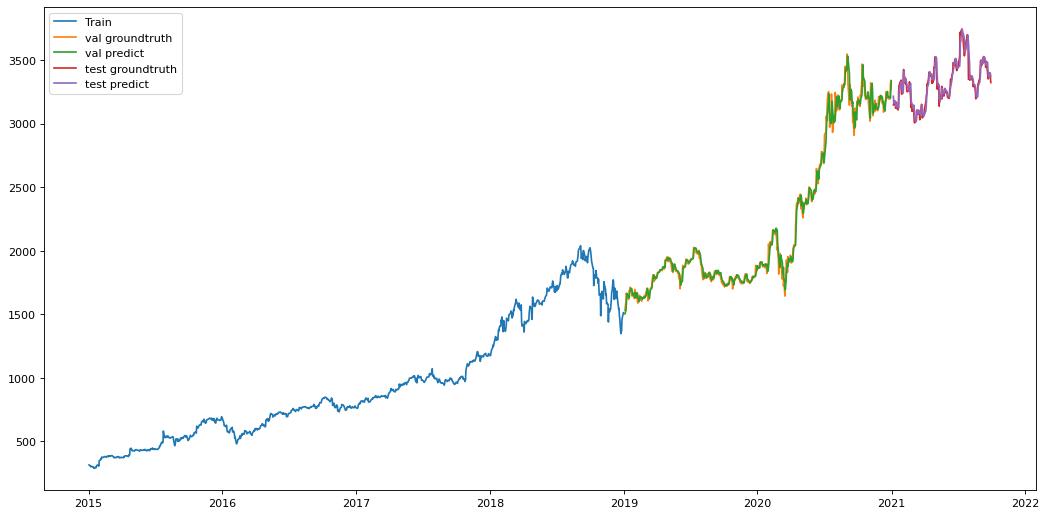

In [149]:
date = valDF.index.values[seq_len:]
plt.figure(dpi = 100)
plt.plot(date, valTarget, label = "val groundtruth")
plt.plot(date, valpred, label = "val predict")
plt.legend()
plt.show()

date = testDF.index.values[seq_len:]
plt.figure(dpi = 100)
plt.plot(date, testTarget, label = "test groundtruth")
plt.plot(date, testpred, label = "test predict")
plt.legend()
plt.show()

plt.figure(figsize=(16,8), dpi = 80)
date = trainDF.index.values[:]
plt.plot(date, trainDF[['Open']], label = "Train")
date = valDF.index.values[seq_len:]
plt.plot(date, valTarget, label = "val groundtruth")
plt.plot(date, valpred, label = "val predict")
date = testDF.index.values[seq_len:]
plt.plot(date, testTarget, label = "test groundtruth")
plt.plot(date, testpred, label = "test predict")
plt.legend()
plt.show()

#GRU

In [155]:
batch = 16
hidden_size = 50
seq_len = 2

In [156]:
trainData, trainTarget = split_sequence(trainDF.values[:,:1], seq_len = seq_len)
valData, valTarget = split_sequence(valDF.values[:,:1],  seq_len = seq_len)
testData, testTarget = split_sequence(testDF.values[:,:1],  seq_len = seq_len)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 50)                7950      
                                                                 
 dense_48 (Dense)            (None, 25)                1275      
                                                                 
 dense_49 (Dense)            (None, 1)                 26        
                                                                 
Total params: 9,251
Trainable params: 9,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
63/63 - 2s - loss: 406203.4688 - mae: 494.6127 - val_loss: 27298.4863 - val_mae: 151.3459 - 2s/epoch - 30ms/step
Epoch 2/15
63/63 - 0s - loss: 2030.6007 - mae: 30.4841 - val_loss: 3122.0103 - val_mae: 39.2818 - 427ms/epoch - 7ms/step
Epoch 3/15
63/63 - 0s - loss: 537.6528 - mae: 13.5316 - val_loss: 2777

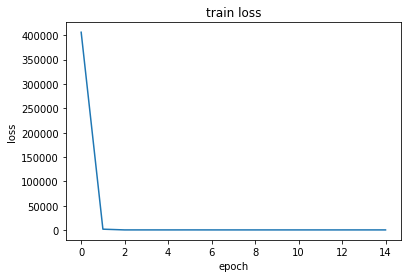

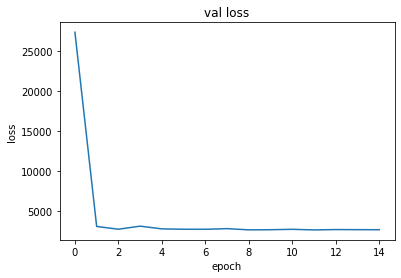

In [157]:
model=Sequential()
model.add(GRU(hidden_size,activation='relu', input_shape=(seq_len, 1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer="adam", metrics = ['mae'])
model.summary()
history = model.fit(trainData, trainTarget,validation_data = (valData, valTarget) ,  epochs=15, batch_size=batch, verbose=2)

valpred = model.predict(valData)
testpred = model.predict(testData)

mae = MeanAbsoluteError()
error = mae(testpred, testTarget)

print(f"Testing Mean Absolute Error = {error}")

plt.plot(history.history['loss'])
plt.title('train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['val_loss'])
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

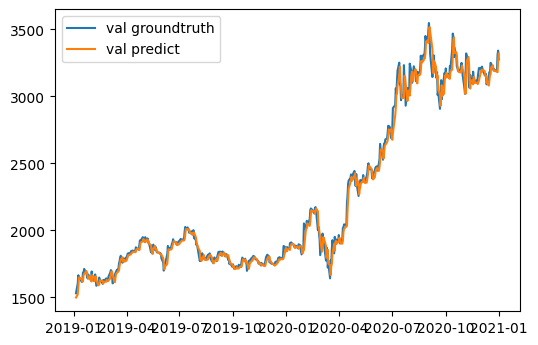

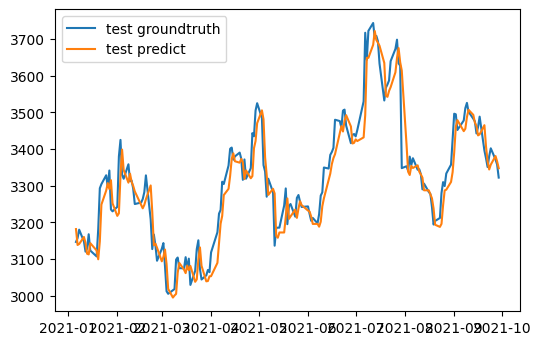

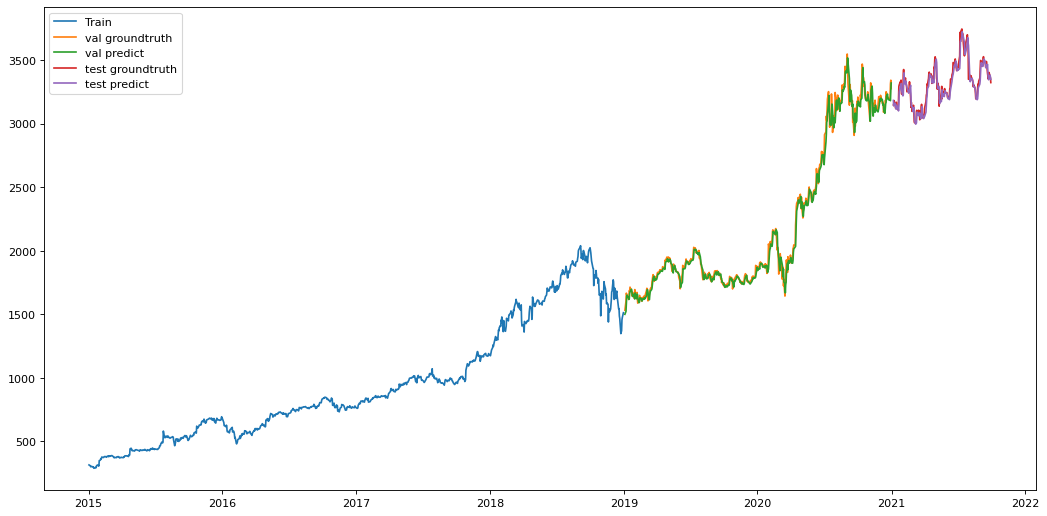

In [153]:
date = valDF.index.values[seq_len:]
plt.figure(dpi = 100)
plt.plot(date, valTarget, label = "val groundtruth")
plt.plot(date, valpred, label = "val predict")
plt.legend()
plt.show()

date = testDF.index.values[seq_len:]
plt.figure(dpi = 100)
plt.plot(date, testTarget, label = "test groundtruth")
plt.plot(date, testpred, label = "test predict")
plt.legend()
plt.show()

plt.figure(figsize=(16,8), dpi = 80)
date = trainDF.index.values[:]
plt.plot(date, trainDF[['Open']], label = "Train")
date = valDF.index.values[seq_len:]
plt.plot(date, valTarget, label = "val groundtruth")
plt.plot(date, valpred, label = "val predict")
date = testDF.index.values[seq_len:]
plt.plot(date, testTarget, label = "test groundtruth")
plt.plot(date, testpred, label = "test predict")
plt.legend()
plt.show()

**Analysis**

**Models**: I use SimpleRNN, LSTM, and GRU to train, test on the same dataset. All models used ReLU as our activation function. Hyperparameters are set the same for comparison reason. I also tried different hyperparameters just to familiar with characteristics of different structures. 

**Performance metric**: I choose MSE as my loss function. Since this is a numerical, time-series data instead of categorical data, MSE works pretty well in all three models. In term of my metrics for validation and testing. I choose Mean Absolute Error (MAE). MAE will evaluate the average different between predicted value and real value. 

**Result**: With larger sequence length, LSTM and GRU preform much better compared to SimpleRNN as Simple will easily encounter gradient explode or vanishing gradient and resulting prediction will become random constant. Overall, GRU performs the best with lowest MAE. However, the differences in general are marginal. Since this is a time-seris data prediction instead of a NLP task. short-term memory problem is less obvious. 

\
**Can traditional feed-forward network to solve the time-series data?**

  Generally, a time series data can possibly be converted to usual features. However, as our sequence get longer, the number of parameters will increase drastically. The pattern will eventually be too complicate for a traditional feed-forward network to capture. It will be very difficult for a traditional feed-forward network to converge. If we use brute force to train by increase number of epoch, our model will eventually overfit.



# Word Embedding

In [1]:
import tensorflow_hub as hub
from scipy.spatial.distance import cosine, euclidean

model = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1")

word1 = 'lung' #@param{type:"string"}
word2 = 'liver' #@param{type:"string"}

# create embeddings
embeddings = model([word1, word2])
print(embeddings.shape)

word1_embedding = embeddings[0].numpy()
word2_embedding = embeddings[1].numpy()
similarity = 1 - cosine(word1_embedding, word2_embedding)
Dissimilarity = euclidean(word1_embedding, word2_embedding) ** 2

print(f"Cosine similarity for {word1} and {word2} is {similarity}")
print(f"Dissimilarity for {word1} and {word2} is {Dissimilarity}")


(2, 50)
Cosine similarity for lung and liver is 0.7658140659332275
Dissimilarity for lung and liver is 0.4683718981634435


In my pre-trained word embedding model, each word will project into a 50 dimensional space. The closer two words are located in the feature space means two words have a better similarity. Therefore, dissimilarity should calculate the absolute distance between two words. The longer two words located, the more dissimilarity score those two words should have. 

In my case, I use euclidean distance as my metrics to define dissimilarity score. The cite and formula are shown below. 

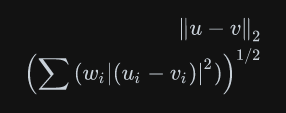

Link: https://en.wikipedia.org/wiki/Euclidean_distance
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html